In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.preprocessing import image

Using TensorFlow backend.


# Set Up MURA Dataset

In [2]:
data_dir = "..\\MURA-v1.1"

train_images_path = pd.read_csv(os.path.join(data_dir, 'train_image_paths.csv'),names=["Train Dataset"])
train_labels = pd.read_csv(os.path.join(data_dir, 'train_labeled_studies.csv'),names=["Train Labeled Studies", "label"])

validation_images_path = pd.read_csv(os.path.join(data_dir, 'valid_image_paths.csv'),names=["Validation Dataset"])
validation_labels = pd.read_csv(os.path.join(data_dir, 'valid_labeled_studies.csv'),names=["Validation Labeled Studies", "label"])

In [3]:
train_images_path = train_images_path.sort_values(by=['Train Dataset'])
train_labels = train_labels.sort_values(by=['Train Labeled Studies'])

validation_images_path = validation_images_path.sort_values(by=['Validation Dataset'])
validation_labels = validation_labels.sort_values(by=['Validation Labeled Studies'])

In [4]:
train_labels['Body Part'] = train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study Type'] = train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])

In [5]:
validation_labels['Body Part'] = validation_labels['Validation Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
validation_labels['Study Type'] = validation_labels['Validation Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])

## Plot Data Statistics

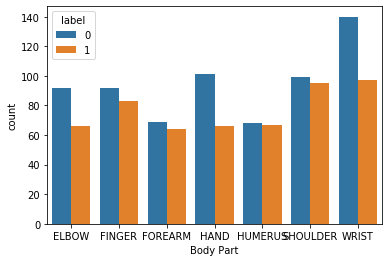

In [6]:
sns.countplot(data=validation_labels, x='Body Part', hue='label')

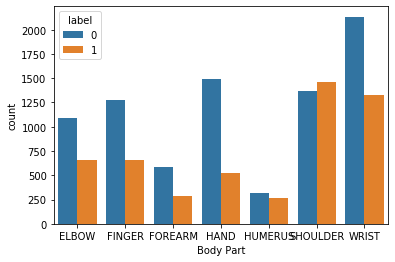

In [7]:
sns.countplot(data=train_labels, x='Body Part', hue='label')

## Read In Training and Validation Data

In [8]:
def get_image_array(image_dir):

    data_path = os.path.join(image_dir,'*g')
    files = glob.glob(data_path)
    data = []
    i=0
    for f1 in files:
        i=i+1
        img = cv2.imread(f1)
        data.append(img)
           
    return data

In [9]:
def load_data(data_dir, limit=None, body_part=None, dataset_type="train"):
    assert (body_part is None) or (type(body_part) == str)
    assert (limit is None) or ((type(limit) == int) and limit >= 0)
    
    train_X, train_y = [], []
    counter = 0
    
    if dataset_type == "train":
        file_path = data_dir + "//train_image_paths.csv"
    elif dataset_type == "validation":
        file_path = data_dir + "//valid_image_paths.csv"
    
    with open(file_path) as csv_file:
        data = pd.read_csv(csv_file, header=None)
        shuffled_data = data.sample(frac=1)
        
        for index, row in shuffled_data.iterrows():

            # Limit the number of read data examples.
            if limit and counter >= limit: break
            
            # Retrieve data specific to a given body part only.
            if body_part is not None and not body_part.upper() in row[0]: continue
                
            image_path = "..//" + row[0]
            img = image.load_img(image_path, target_size = (224, 224))
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis = 0)
            #img = img.reshape((1,) + img.shape)

            train_X.append(img)
            train_y.append(label_image(row[0]))

            counter = counter + 1
            
    return np.asarray(train_X), np.asarray(train_y)

In [10]:
def label_image(img_path):
    return 1 if "positive" in img_path else 0

In [11]:
train_X, train_y = load_data("..//MURA-v1.1", limit=2000, dataset_type="train")
validation_X, validation_y = load_data("..//MURA-v1.1", limit=1000, dataset_type="validation")

In [12]:
train_X_HUMERUS, train_y_HUMERUS = load_data("..//MURA-v1.1", limit=2000, body_part="HUMERUS", dataset_type="train")
validation_X_HUMERUS, validation_y_HUMERUS = load_data("..//MURA-v1.1", limit=1000, body_part="HUMERUS", dataset_type="validation")

In [13]:
train_X_WRIST, train_y_WRIST = load_data("..//MURA-v1.1", limit=2000, body_part="WRIST", dataset_type="train")
validation_X_WRIST, validation_y_WRIST = load_data("..//MURA-v1.1", limit=1000, body_part="WRIST", dataset_type="validation")

In [14]:
train_X = train_X.reshape(-1, 224, 224, 3) / 255.0
validation_X = validation_X.reshape(-1, 224, 224, 3) / 255.0

In [15]:
train_X_HUMERUS = train_X_HUMERUS.reshape(-1, 224, 224, 3) / 255.0
validation_X_HUMERUS = validation_X_HUMERUS.reshape(-1, 224, 224, 3) / 255.0

In [16]:
train_X_WRIST = train_X_WRIST.reshape(-1, 224, 224, 3) / 255.0
validation_X_WRIST = validation_X_WRIST.reshape(-1, 224, 224, 3) / 255.0

In [17]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [18]:
print(train_X_HUMERUS.shape)
print(train_y_HUMERUS.shape)

(1272, 224, 224, 3)
(1272,)


# Inception V1 Model

In [19]:
def plotingModel(history_):

    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title("Train vs Validation Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(False)

    plt.legend(['train', 'test'], loc='upper right')

In [23]:
inception_base_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/feature_vector/4")

inception_model = tf.keras.Sequential()
inception_model.add(inception_base_layer)
inception_model.add(tf.keras.layers.Flatten())
inception_model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
inception_model.add(tf.keras.layers.Dropout(0.5))
inception_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

inception_model.build([None, 224, 224, 3])  # Batch input shape.
inception_model.compile(optimizer = 'adamax', loss="binary_crossentropy", metrics = ['accuracy'])
inception_model.summary()
#history_inception = inception_model.fit(train_X_WRIST, train_y_WRIST, epochs=10, batch_size=32, validation_data=(validation_X_WRIST, validation_y_WRIST))

#inception_model.evaluate(train_X / 255.0, train_y)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  5607184   
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  262400    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  257       
Total params: 5,869,841
Trainable params: 262,657
Non-trainable params: 5,607,184
_________________________________________________________________


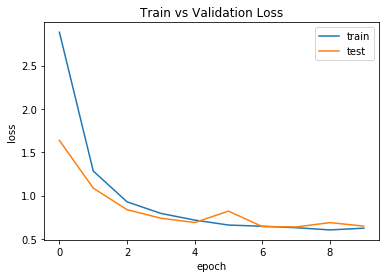

In [21]:
plotingModel(history_inception)

## Class: Finger

Train on 5106 samples, validate on 461 samples
Epoch 1/5
5106/5106 [==============================] - 278s 55ms/sample - loss: 0.6482 - accuracy: 0.6708 - val_loss: 0.6511 - val_accuracy: 0.7028
Epoch 2/5
5106/5106 [==============================] - 227s 44ms/sample - loss: 0.6133 - accuracy: 0.6888 - val_loss: 0.6822 - val_accuracy: 0.6746
Epoch 3/5
5106/5106 [==============================] - 218s 43ms/sample - loss: 0.6025 - accuracy: 0.6982 - val_loss: 0.7804 - val_accuracy: 0.5380
Epoch 4/5
5106/5106 [==============================] - 216s 42ms/sample - loss: 0.5935 - accuracy: 0.7129 - val_loss: 0.6262 - val_accuracy: 0.7223
Epoch 5/5
5106/5106 [==============================] - 215s 42ms/sample - loss: 0.6038 - accuracy: 0.7002 - val_loss: 0.6069 - val_accuracy: 0.7180


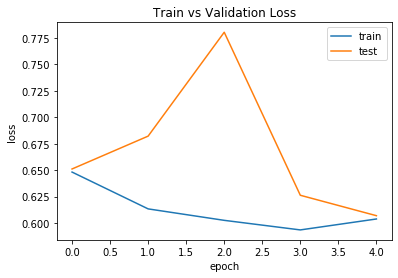

In [22]:
train_X_FINGER, train_y_FINGER = load_data("..//MURA-v1.1", body_part="FINGER", dataset_type="train")
validation_X_FINGER, validation_y_FINGER = load_data("..//MURA-v1.1", body_part="FINGER", dataset_type="validation")

train_X_FINGER = train_X_FINGER.reshape(-1, 224, 224, 3) / 255.0
validation_X_FINGER = validation_X_FINGER.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_FINGER, train_y_FINGER, epochs=5, batch_size=32, validation_data=(validation_X_FINGER, validation_y_FINGER))

plotingModel(history_inception)

## Class: Elbow

In [ ]:
train_X_ELBOW, train_y_ELBOW = load_data("..//MURA-v1.1", body_part="ELBOW", dataset_type="train")
validation_X_ELBOW, validation_y_ELBOW = load_data("..//MURA-v1.1", body_part="ELBOW", dataset_type="validation")

train_X_ELBOW = train_X_ELBOW.reshape(-1, 224, 224, 3) / 255.0
validation_X_ELBOW = validation_X_ELBOW.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_ELBOW, train_y_ELBOW, epochs=5, batch_size=32, validation_data=(validation_X_ELBOW, validation_y_ELBOW))

plotingModel(history_inception)

Train on 4931 samples, validate on 465 samples
Epoch 1/5
4931/4931 [==============================] - 420s 85ms/sample - loss: 2.7421 - accuracy: 0.6504 - val_loss: 1.8682 - val_accuracy: 0.6559
Epoch 2/5
4931/4931 [==============================] - 226s 46ms/sample - loss: 1.5308 - accuracy: 0.7153 - val_loss: 1.2945 - val_accuracy: 0.7118
Epoch 3/5
2080/4931 [===========>..................] - ETA: 2:07 - loss: 1.2354 - accuracy: 0.7111